In [1]:
import rebound
import time
import sys
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c

# local imports
import heartbeat
import globs
import metasim

In [2]:
read_only = True

systems = []

def run_sim(filestem='test/test',tmoons=1e4):
    
    # global variables

    globs.initialise()

    globs.glob_dclo = 1. #CE distance to check in rH
    #dir = 'test/'
    globs.glob_archive = ''
    #globals.glob_names = []
    globs.glob_is_close = False

    system = metasim.MetaSim(filestem=filestem,tmoons=tmoons)
    if not read_only:
        system.run_planets()
        if globs.glob_is_close:
            system.rewind()
            system.add_moons()
            system.run_moons()

    system.analyse()
    system.make_timeline()
    
    systems.append(system)

Simulation test/test0000



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.5230961908595093 e=0.502902542515528
Planet2 bound to EPIC220208795: a=1.180344986922353 e=0.25918404013605434
Ganymede1 bound to Planet1: a=0.007337035168043923 e=0.17136403975216613
Callisto1 bound to EPIC220208795: a=13.733965581814209 e=0.7917730476682313
Simulation test/test0001



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.3960080669467134 e=0.19497817817745552
Planet2 bound to EPIC220208795: a=2.7396254556869084 e=0.2945878187802894
Callisto1 bound to Galaxy: a=-13.175694864830719 e=10.547665277591499
Callisto2 bound to EPIC220208795: a=5.2139944159385525 e=0.906670368852637
Simulation test/test0002



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.8412457009567613 e=0.05681211466202166
Europa2 bound to Galaxy: a=-19.00410441266794 e=1.6655199484335637
Simulation test/test0003



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9668947718004856 e=0.44965196130084445
Planet2 bound to EPIC220208795: a=9.984103378732131 e=0.8259135068936593
Callisto2 bound to EPIC220208795: a=78.77639530608879 e=0.9946576814486898
Simulation test/test0004



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=12.854676022410699 e=0.8457691257647686
Planet2 bound to EPIC220208795: a=1.037684119621104 e=0.5435728445536541
Io1 bound to Planet1: a=0.003213481406908524 e=0.19284656217549379
Callisto1 bound to Galaxy: a=-6.265679847919489 e=6.784485278103186
Ganymede2 bound to Planet2: a=0.004384897877315929 e=0.08509427531890691
Simulation test/test0005



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=11.613259120590202 e=0.8304638965555443
Planet2 bound to EPIC220208795: a=1.0032599076293136 e=0.581726462907843
Io1 bound to Planet1: a=0.009054559727572475 e=0.5572806953155697
Ganymede1 bound to EPIC220208795: a=6.16123781257066 e=0.771230455233644
Callisto1 bound to EPIC220208795: a=1.4052647794895718 e=0.7073609256255616
Europa2 bound to Galaxy: a=-19.376765290391017 e=1.010634110703735
Callisto2 bound to EPIC220208795: a=507.43948737313514 e=0.9997827899416007
Simulation test/test0006



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.871166593986678 e=0.10104427098397288
Callisto1 bound to Galaxy: a=-6.88310121132742 e=6.816510977521644
Ganymede2 bound to Galaxy: a=-273.3634167010412 e=1.0546375085077053
Callisto2 bound to Galaxy: a=-93.55846884727904 e=1.6037321075412638
Simulation test/test0007



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0702551696260774 e=0.5057170515802809
Planet2 bound to EPIC220208795: a=4.975992965258493 e=0.6141632712571277
Simulation test/test0008



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.7531019552362195 e=0.059058120051460744
Europa1 bound to Galaxy: a=-15.289426633335063 e=11.78866247338128
Ganymede1 bound to EPIC220208795: a=0.8760107520350422 e=0.6379612725211079
Callisto1 bound to Galaxy: a=-52.522509936559786 e=1.020947170040978
Io2 bound to Galaxy: a=-9223.336871154455 e=1.000066219423821
Simulation test/test0009



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.1635986465035195 e=0.3852458767464925
Planet2 bound to EPIC220208795: a=1.3097131011710594 e=0.2228017093952855
Io1 bound to Planet1: a=0.0025808309967916515 e=0.20414322011148084
Ganymede1 bound to EPIC220208795: a=141.42409326675178 e=0.989488068826495
Callisto1 bound to EPIC220208795: a=25.74378746133945 e=0.9097954256639875
Europa2 bound to EPIC220208795: a=2.449960194045153 e=0.35778308255904034
Callisto2 bound to EPIC220208795: a=17.59015364295489 e=0.8763760073332187
Simulation test/test0010



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7333316550556828 e=0.12506301492246943
Ganymede1 bound to Galaxy: a=-90.21753023680894 e=1.5892486636468977
Io2 bound to Planet2: a=0.009813914449011344 e=0.5296869011402712
Simulation test/test0011



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.9399099321737998 e=0.03975419985494079
Io2 bound to EPIC220208795: a=5.666172118424107 e=0.39966423562791265
Europa2 bound to EPIC220208795: a=1.78409135856706 e=0.43775517704595673
Simulation test/test0012



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=5.684866484032115 e=0.6657126369414671
Planet2 bound to EPIC220208795: a=1.0758291279185186 e=0.4428738896920731
Europa1 bound to Galaxy: a=-3.124702833043535 e=26.717061015690074
Ganymede1 bound to EPIC220208795: a=120.27149471641204 e=0.9913281275581761
Callisto1 bound to Galaxy: a=-4.892743445576081 e=17.957279576382906
Simulation test/test0013



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.7820640450903302 e=0.403941506785327
Planet2 bound to EPIC220208795: a=1.1765947777235288 e=0.5292488713388922
Io2 bound to EPIC220208795: a=5.09952531756579 e=0.18594612447956052
Callisto2 bound to EPIC220208795: a=119.22088143237978 e=0.9826627635912656
Simulation test/test0014



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.898686667938264 e=0.065360671491673
Ganymede1 bound to Galaxy: a=-36.8783268061079 e=2.782139269285634
Callisto1 bound to EPIC220208795: a=12.088089046530262 e=0.8346553929310637
Ganymede2 bound to Galaxy: a=-125.84497198762489 e=1.780188461784902
Callisto2 bound to Galaxy: a=-80.0851713414021 e=2.1548249637463037
Simulation test/test0015



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=6.739961511654086 e=0.7273555217909684
Planet2 bound to EPIC220208795: a=1.0447096797203912 e=0.44337953730360097
Callisto1 bound to EPIC220208795: a=10.683744042245241 e=0.8868420189000732
Callisto2 bound to Galaxy: a=-11.53337302686841 e=5.836413118530344
Simulation test/test0016



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Restored from save
Planet1 bound to EPIC220208795: a=0.9281865328930793 e=0.4278921082717431
Planet2 bound to EPIC220208795: a=9.802873644366619 e=0.839042703091872
Io1 bound to Planet1: a=0.002714415334218278 e=0.14514284666638191
Europa1 bound to Planet2: a=0.005066330364742198 e=0.2343614618329893
Callisto1 bound to Galaxy: a=-14.692127319131988 e=1.3917416172956982
Io2 bound to Planet2: a=0.0027302891988252613 e=0.12906390198902543
Simulation test/test0017



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.3233209251395113 e=0.2582955395801195
Planet2 bound to EPIC220208795: a=3.0305472848281645 e=0.36226558606274106
Europa2 bound to Galaxy: a=-60.47207789039577 e=1.018742782085546
Callisto2 bound to Galaxy: a=-7.284069833227213 e=1.1142954153478162
Simulation test/test0018



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.286386379201293 e=0.2136407114088829
Planet2 bound to EPIC220208795: a=2.965688648550829 e=0.392998316611281
Ganymede1 bound to Planet1: a=0.007151520278262602 e=0.29052365347773923
Callisto1 bound to Planet1: a=0.01251942358751999 e=0.06487485126550344
Ganymede2 bound to Planet2: a=0.007081428311379781 e=0.33475231181437654
Callisto2 bound to Planet2: a=0.012790064452431197 e=0.24347697459407594
Simulation test/test0019



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0357906111280097 e=0.6703052880605278
Planet2 bound to EPIC220208795: a=6.496325737610852 e=0.6574057863660747
Io1 bound to Planet1: a=0.0027817251543618645 e=0.06351834930027256
Io2 bound to Planet2: a=0.002985606831903135 e=0.173775678011801
Simulation test/test0020



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=29.867707110626927 e=0.93885806633255
Planet2 bound to EPIC220208795: a=0.879049237112453 e=0.6855573744456008
Ganymede1 bound to Planet1: a=0.00686732771891077 e=0.4737339424182662
Callisto1 bound to Galaxy: a=-5.946313873569557 e=5.791993943249928
Io2 bound to Planet2: a=0.0032138396803293038 e=0.3884608038452579
Callisto2 bound to EPIC220208795: a=5.526542602045998 e=0.651657846200688
Simulation test/test0021



/Users/alexander/research/circumplanetary_discs/rebound/simulations/moons/metasim.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(xsize,ysize))
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7614390642285387 e=0.04474984067127734
Io1 bound to EPIC220208795: a=312.8208305998811 e=0.9899613168814951
Ganymede1 bound to Galaxy: a=-12.009661895898356 e=12.93314499155171
Io2 bound to EPIC220208795: a=1.5867958315970938 e=0.6046123973924469
Ganymede2 bound to Galaxy: a=-3.50076968294452 e=33.18810564736873
Callisto2 bound to Galaxy: a=-26.143739667158613 e=6.114365202548345
Simulation test/test0022



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8083274355219012 e=0.07074680777434891
Callisto1 bound to EPIC220208795: a=1.1577029373844265 e=0.4798215418427488
Simulation test/test0023



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8977420885120684 e=0.061527038455778574
Ganymede1 bound to Galaxy: a=-3.4241598687585286 e=46.078610145608614
Callisto1 bound to EPIC220208795: a=14.840129018515373 e=0.8931706422328392
Simulation test/test0024



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.1666432543484413 e=0.39113860113228377
Planet2 bound to EPIC220208795: a=3.5679888668138178 e=0.46572968521436775
Callisto2 bound to Galaxy: a=-224.2747286491967 e=1.0198516034752105
Simulation test/test0025



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8732839150126093 e=0.06593749923228312
Io1 bound to Planet1: a=0.008908049490261492 e=0.49468132374570606
Simulation test/test0026



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.772694291116392 e=0.4714865658245064
Planet2 bound to EPIC220208795: a=1.26882862250622 e=0.30551554755857147
Europa1 bound to Galaxy: a=-1.6675229762805661 e=45.14958884414147
Europa2 bound to EPIC220208795: a=15.256777558143819 e=0.9297098652761757
Simulation test/test0027



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9424794137252558 e=0.669106452238559
Planet2 bound to EPIC220208795: a=9.637023567559647 e=0.7927099034127243
Io1 bound to Planet1: a=0.002750729330511011 e=0.1387006870913123
Europa1 bound to Planet1: a=0.004113726832338442 e=0.13590096928187304
Io2 bound to Planet2: a=0.0028403766141743086 e=0.21087481536627703
Europa2 bound to Planet2: a=0.005352196030684833 e=0.3729580205579522
Simulation test/test0028



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.446353378808454 e=0.27713017735756323
Planet2 bound to EPIC220208795: a=1.3322589986103417 e=0.4743686782379082
Io1 bound to Galaxy: a=-45.05478491885988 e=1.1064632134354095
Io2 bound to Galaxy: a=-3.079782919323544 e=25.43207476513858
Callisto2 bound to EPIC220208795: a=62.44672700605391 e=0.9714592427034567
Simulation test/test0029



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save
Moons never added
Simulation test/test0030

Restored from save
Moons never added
Simulation test/test0031

Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.1630842125846974 e=0.46924354268204305
Planet2 bound to EPIC220208795: a=3.583722945718002 e=0.4385524523530825
Callisto1 bound to EPIC220208795: a=0.8475205031214812 e=0.3536006213817621
Europa2 bound to EPIC220208795: a=5.472391855136349 e=0.5399160426951647
Ganymede2 bound to EPIC220208795: a=71.13314947040337 e=0.9416409051091728
Callisto2 bound to Galaxy: a=-5.875685618834459 e=1.968215897628882
Simulation test/test0032



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.773301815168208 e=0.06947014426955718
Ganymede1 bound to EPIC220208795: a=3.78427226154206 e=0.7980991878844582
Callisto1 bound to Galaxy: a=-24.171583414108397 e=2.9013102777214077
Simulation test/test0033



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=5.655638221027473 e=0.6948991092280263
Planet2 bound to EPIC220208795: a=1.0257034629934303 e=0.4180037277572505
Europa1 bound to Planet1: a=0.004038825035348438 e=0.3228935089060798
Io2 bound to Planet2: a=0.0028449438806759067 e=0.03585628502339955
Europa2 bound to Planet2: a=0.00495774619437452 e=0.2707301368268955
Ganymede2 bound to EPIC220208795: a=11.136600410209152 e=0.7380312497708235
Callisto2 bound to EPIC220208795: a=23.035268204342493 e=0.9558010946477834
Simulation test/test0034



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.4016321416836435 e=0.18536745216250894
Planet2 bound to EPIC220208795: a=2.717092112100184 e=0.29116135224047957
Io1 bound to Planet1: a=0.007472634101075698 e=0.5073688425379658
Callisto1 bound to EPIC220208795: a=3.977508260843844 e=0.249962853316538
Io2 bound to Planet2: a=0.007980678179097069 e=0.3566948854449891
Simulation test/test0035



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.478068774448054 e=0.10325474340603957
Planet2 bound to EPIC220208795: a=1.2741248338486928 e=0.6036587312220545
Ganymede1 bound to Planet1: a=0.0075891522472380174 e=0.43189216116363094
Io2 bound to Planet2: a=0.002820992777452561 e=0.05897242915932272
Europa2 bound to Planet2: a=0.0044365212553751495 e=0.07781933759694191
Simulation test/test0036



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7693014606036632 e=0.049861051626897204
Callisto1 bound to Galaxy: a=-7.0264200769925385 e=11.006021056881375
Europa2 bound to Galaxy: a=-6.326743805307436 e=18.567477577579385
Simulation test/test0037



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.4574995015902505 e=0.1341434524885464
Planet2 bound to EPIC220208795: a=2.7068163156951655 e=0.2691368614238026
Callisto1 bound to EPIC220208795: a=1.1928979945188511 e=0.44035771934102
Simulation test/test0038



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=5.232102295520758 e=0.6087322620462187
Planet2 bound to EPIC220208795: a=1.0183521654741754 e=0.5871808015422405
Europa1 bound to EPIC220208795: a=37.7244627133169 e=0.9626894116524225
Ganymede1 bound to Galaxy: a=-17.351171754489688 e=7.742811685651876
Europa2 bound to EPIC220208795: a=1.2154573622162428 e=0.6541692126342986
Ganymede2 bound to EPIC220208795: a=4.881384223387601 e=0.8955831565470628
Simulation test/test0039



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=2.953052334201387 e=0.21622830787598515
Planet2 bound to EPIC220208795: a=1.2283813802399561 e=0.4577985908388928
Ganymede1 bound to EPIC220208795: a=12.869962743214558 e=0.7888114005409357
Callisto1 bound to Galaxy: a=-11.00637890910229 e=1.520089949720851
Callisto2 bound to Galaxy: a=-3.340270854681294 e=25.21887176250448
Simulation test/test0040



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.883220153527907 e=0.0700924943341609
Europa1 bound to Galaxy: a=-17.79692228392023 e=2.6218626619914738
Ganymede1 bound to Galaxy: a=-37.69303301554542 e=1.4638649144568072
Ganymede2 bound to Galaxy: a=-31.842425856932913 e=4.530816165263791
Callisto2 bound to EPIC220208795: a=673.9099305284699 e=0.9979354186911549
Simulation test/test0041



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7811741538161159 e=0.09372354933001552
Ganymede1 bound to EPIC220208795: a=1.12839890103956 e=0.6409238371348296
Callisto1 bound to Galaxy: a=-2.3905315468976687 e=72.06875259675746
Europa2 bound to EPIC220208795: a=7.047414003830834 e=0.8913941429504777
Ganymede2 bound to EPIC220208795: a=28.793528635862415 e=0.918808123968569
Callisto2 bound to Galaxy: a=-4.414086494028579 e=14.01448507864135
Simulation test/test0042



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0859908507449185 e=0.6260021497552009
Planet2 bound to EPIC220208795: a=7.6654797761829165 e=0.7044175627479892
Io1 bound to Planet1: a=0.002821040945157826 e=0.004496316902358006
Europa1 bound to Planet1: a=0.004487510832053883 e=0.011334187566597787
Ganymede1 bound to Planet1: a=0.00715777331881352 e=0.00736064064927103
Callisto1 bound to Planet1: a=0.012505275978980442 e=0.07670532875852543
Io2 bound to Planet2: a=0.002820948100672864 e=0.0012339274952407875
Europa2 bound to Planet2: a=0.004489007396364087 e=0.007818613655756531
Ganymede2 bound to Planet2: a=0.007158709480625299 e=0.0019864058598159005
Callisto2 bound to Planet2: a=0.012598229488411938 e=0.004805893887581988
Simulation test/test0043



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.4394364432970905 e=0.11122921063023339
Planet2 bound to EPIC220208795: a=2.1018729203381312 e=0.14330053041107008
Callisto1 bound to Galaxy: a=-9.441980773359312 e=9.987949122303277
Simulation test/test0044



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8228569257582656 e=0.10813132332308674
Europa2 bound to Galaxy: a=-20.446659254350568 e=10.326860603388806
Ganymede2 bound to Galaxy: a=-4.659869961369454 e=33.65012843044594
Callisto2 bound to Galaxy: a=-25.053337538126932 e=3.677656543020106
Simulation test/test0045



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.8901322242329905 e=0.04644352687834979
Callisto1 bound to Galaxy: a=-32.03171838923226 e=1.0440338429639766
Callisto2 bound to EPIC220208795: a=16.036469399857378 e=0.8781882136616408
Simulation test/test0046



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.237865334110834 e=0.4214288446341073
Planet2 bound to EPIC220208795: a=3.446475255604938 e=0.3895998416561905
Ganymede1 bound to Galaxy: a=-5.2058032939711625 e=15.57821482869527
Callisto1 bound to EPIC220208795: a=14.596889244041558 e=0.8862404242400713
Ganymede2 bound to Galaxy: a=-0.9904476561975266 e=21.796284348267655
Callisto2 bound to EPIC220208795: a=35.122636263750195 e=0.9614079983663057
Simulation test/test0047



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9290935306798427 e=0.5146889794945408
Planet2 bound to EPIC220208795: a=14.026232900427042 e=0.8719530678133465
Io2 bound to Planet2: a=0.004903251127880831 e=0.3962231667141715
Ganymede2 bound to EPIC220208795: a=11.87808369485391 e=0.7889755172609143
Simulation test/test0048



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.319161256384933 e=0.1487937019950446
Planet2 bound to EPIC220208795: a=2.3833292706117146 e=0.2895603732217285
Callisto2 bound to EPIC220208795: a=9.853587125512366 e=0.715986369324705
Simulation test/test0049



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=7.471079324435083 e=0.7755832444393207
Planet2 bound to EPIC220208795: a=0.9718415989580509 e=0.3861638319408524
Io1 bound to Planet1: a=0.00280932526121563 e=0.12755621399886297
Callisto1 bound to Galaxy: a=-5.99303289257694 e=17.560582696901783
Ganymede2 bound to Planet2: a=0.014212357858406723 e=0.046015243611272454
Simulation test/test0050



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8413606406990075 e=0.056954446193241894
Ganymede2 bound to Planet1: a=0.013445917096013742 e=0.5726841015677474
Simulation test/test0051



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.8908600367148947 e=0.6058415049467525
Planet2 bound to EPIC220208795: a=35.25863429487454 e=0.9455838084393846
Callisto1 bound to EPIC220208795: a=23.089014914833047 e=0.8149546375062686
Ganymede2 bound to EPIC220208795: a=4.2570203034821406 e=0.5830475496985879
Simulation test/test0052



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save
Moons never added
Simulation test/test0053

Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=4.942608667187642 e=0.5675796826281836
Planet2 bound to EPIC220208795: a=1.1244930976472465 e=0.5173060853661753
Callisto1 bound to EPIC220208795: a=118.87270063738383 e=0.9802011915938631
Simulation test/test0054



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.2337147371753692 e=0.4050143123578086
Planet2 bound to EPIC220208795: a=4.167622649504292 e=0.4966283035783706
Io1 bound to Planet1: a=0.0028208982424668843 e=0.023804542827114222
Europa1 bound to Planet1: a=0.00452351350330601 e=0.15850530825427708
Ganymede1 bound to Planet1: a=0.00714033284120712 e=0.042677469560375575
Io2 bound to Planet2: a=0.0028203597075948713 e=0.06234077421014693
Europa2 bound to Planet2: a=0.004491353397924761 e=0.11305705054374199
Ganymede2 bound to Planet2: a=0.007036547899735212 e=0.09089808418796341
Simulation test/test0055



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9848876606024879 e=0.3974009572174677
Planet2 bound to EPIC220208795: a=6.108009314440897 e=0.7276667438862324
Europa1 bound to EPIC220208795: a=16.47509794271339 e=0.9117100832191906
Callisto1 bound to Galaxy: a=-169.74309574328788 e=1.084535261938358
Ganymede2 bound to Galaxy: a=-2.693562610550558 e=19.252577706441734
Simulation test/test0056



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=8.64394315647525 e=0.7968591407610376
Planet2 bound to EPIC220208795: a=1.0418077201890765 e=0.3512505576937352
Io1 bound to Planet1: a=0.0028210157628328594 e=0.0024283821598424966
Europa1 bound to Planet1: a=0.004487603666034507 e=0.003233324009526305
Ganymede1 bound to Planet1: a=0.007157048969448657 e=0.007862097465322621
Callisto1 bound to Planet1: a=0.012586535367508688 e=0.010111950931189355
Io2 bound to Planet2: a=0.002820953593257757 e=0.009313799604603702
Europa2 bound to Planet2: a=0.0044882486717011056 e=0.017571940260655585
Ganymede2 bound to Planet2: a=0.007156037199461156 e=0.0026210094365853275
Callisto2 bound to Planet2: a=0.0125990760938478 e=0.011323522871632762
Simulation test/test0057



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Restored from save
Planet1 bound to EPIC220208795: a=0.934501359414839 e=0.6136317162830826
Planet2 bound to EPIC220208795: a=10.339695095136122 e=0.8153106183226182
Io1 bound to Planet1: a=0.0028198060621632617 e=0.046826160134089245
Europa1 bound to Planet1: a=0.004500021903659942 e=0.09035456698851052
Ganymede1 bound to Planet1: a=0.00717027184386776 e=0.01103487466912865
Callisto1 bound to Planet1: a=0.012465599405215924 e=0.1363478396216577
Io2 bound to Planet2: a=0.002821214228922607 e=0.010819915844077104
Europa2 bound to Planet2: a=0.0044861384036402495 e=0.03721968160064777
Ganymede2 bound to Planet2: a=0.007157646617940872 e=0.0657263231587984
Callisto2 bound to Planet2: a=0.012411251773729154 e=0.09809616870479561
Simulation test/test0058



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=4.710852138823748 e=0.5398702439021876
Planet2 bound to EPIC220208795: a=1.0933045416372582 e=0.5872072598707901
Ganymede1 bound to EPIC220208795: a=418.2609031975921 e=0.9984953344196887
Callisto1 bound to Galaxy: a=-1.613162102369366 e=58.97002281916982
Ganymede2 bound to Galaxy: a=-15.670646048786173 e=1.3061897789343646
Simulation test/test0059



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0113472475810381 e=0.7148553460002228
Planet2 bound to EPIC220208795: a=15.789171737581976 e=0.8529705716767142
Callisto1 bound to EPIC220208795: a=7.634438853940496 e=0.546111886409676
Ganymede2 bound to EPIC220208795: a=18.26463751824958 e=0.8064629705808101
Simulation test/test0060



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=2.7654688569781265 e=0.16854478471874929
Planet2 bound to EPIC220208795: a=1.3750609698368847 e=0.3485373769694349
Io2 bound to Planet2: a=0.002615375212588736 e=0.1402605553945566
Callisto2 bound to EPIC220208795: a=1.8933350602633052 e=0.5617626254454751
Simulation test/test0061



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=2.6091287906927465 e=0.13328681158816924
Planet2 bound to EPIC220208795: a=1.2719538237910726 e=0.43740135869070934
Europa1 bound to Galaxy: a=-8.472365968789129 e=9.17856485065838
Callisto2 bound to Galaxy: a=-150.38386896310604 e=1.0163321847826994
Simulation test/test0062



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.9245313282536034 e=0.05023701788052342
Europa1 bound to EPIC220208795: a=79616.69177939915 e=0.9999982565941161
Ganymede1 bound to Galaxy: a=-37.88366444939948 e=1.811545393332324
Callisto1 bound to Galaxy: a=-384.1279240231467 e=1.0114057413565432
Ganymede2 bound to Galaxy: a=-8.186106953323529 e=13.920715363825591
Simulation test/test0063



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=5.334212656944905 e=0.680980465589637
Planet2 bound to EPIC220208795: a=1.028801295576295 e=0.39072830229957783
Io1 bound to Planet1: a=0.0030882649164459875 e=0.3913199148669743
Ganymede1 bound to Planet1: a=0.00762359228992168 e=0.11312295936975614
Europa2 bound to Planet2: a=0.004460262214652321 e=0.19710029261806586
Ganymede2 bound to Planet2: a=0.007175817504645469 e=0.14024992463868405
Simulation test/test0064



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.785639728964747 e=0.14858422102796753
Ganymede1 bound to Planet2: a=0.006968446756736698 e=0.3134333891760128
Simulation test/test0065



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=7.764156983449353 e=0.7229331176653733
Planet2 bound to EPIC220208795: a=1.0209239316541923 e=0.6282477595857764
Ganymede1 bound to EPIC220208795: a=12.020011915325986 e=0.6697715000248031
Callisto1 bound to EPIC220208795: a=28.963825109692046 e=0.9340758804468218
Io2 bound to EPIC220208795: a=15.414400304544914 e=0.8376323840822786
Ganymede2 bound to EPIC220208795: a=27.573530176504658 e=0.9304430225131091
Simulation test/test0066

Restored from save
Moons never added
Simulation test/test0067

Run ended with ejection and no CE
Restored from save
Moons never added
Simulation test/test0068



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.4387914531047308 e=0.18531510688101968
Planet2 bound to EPIC220208795: a=2.6043876472422074 e=0.23399040962702988
Io1 bound to Planet1: a=0.00280378244651521 e=0.05810091119031292
Ganymede1 bound to Galaxy: a=-18.585514481366562 e=1.1614968531841765
Callisto1 bound to Galaxy: a=-2.5923583102127052 e=8.78153396243814
Io2 bound to Planet2: a=0.0029703130251574096 e=0.18542589773105964
Simulation test/test0069



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.3768750467938289 e=0.23648056933725697
Planet2 bound to EPIC220208795: a=2.8142180494586864 e=0.3119142986346283
Ganymede2 bound to EPIC220208795: a=81.84601725672675 e=0.9733882708367706
Simulation test/test0070



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7292688163437717 e=0.05242758846306511
Europa1 bound to Galaxy: a=-110.86114438031275 e=1.462888067796766
Ganymede1 bound to EPIC220208795: a=534.1058702619338 e=0.9743064136636678
Callisto1 bound to Galaxy: a=-7.0997469255181445 e=16.124256546146153
Europa2 bound to Galaxy: a=-1172.9760293099896 e=1.000025571132899
Callisto2 bound to EPIC220208795: a=24.658958659937756 e=0.9143786452899368
Simulation test/test0071



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save
Moons never added
Simulation test/test0072

Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.8812946545371483 e=0.06255483921619041
Europa1 bound to Galaxy: a=-10.321960687086511 e=10.704413071068032
Ganymede1 bound to Galaxy: a=-57.07315169628725 e=2.2270794314004014
Callisto2 bound to Galaxy: a=-184.6602335487732 e=1.2738901973167913
Simulation test/test0073



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.0644920362261117 e=0.5830193259981301
Planet2 bound to EPIC220208795: a=8.250283554522317 e=0.7241405207171165
Io1 bound to Planet1: a=0.00290701245245433 e=0.1216722323143537
Ganymede1 bound to Planet1: a=0.007661507206428415 e=0.2113108957857982
Io2 bound to Planet2: a=0.0030667425549741013 e=0.425615079959021
Ganymede2 bound to Planet2: a=0.007855758027562033 e=0.1228228968059526
Simulation test/test0074



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.809151212061188 e=0.1045275905500582
Ganymede1 bound to Galaxy: a=-34.69409834159216 e=2.1096918207014275
Callisto2 bound to EPIC220208795: a=74.47125540931094 e=0.971176145605311
Simulation test/test0075



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=11.503800749419336 e=0.8368065739005938
Planet2 bound to EPIC220208795: a=0.9328577636413525 e=0.6112011140150755
Callisto1 bound to Galaxy: a=-93.79646186645255 e=1.0454301701735818
Callisto2 bound to EPIC220208795: a=45.26195824233157 e=0.9878880539105706
Simulation test/test0076

Restored from save
Moons never added
Simulation test/test0077



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=18.93726636549427 e=0.8956490994501819
Planet2 bound to EPIC220208795: a=0.9873859085720872 e=0.5688979423969716
Europa1 bound to EPIC220208795: a=2.274609600765972 e=0.7491467190456336
Ganymede1 bound to EPIC220208795: a=79.20368938260724 e=0.972625153281584
Callisto2 bound to EPIC220208795: a=5.343034820228024 e=0.7028089144426098
Simulation test/test0078



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=8.839075881513658 e=0.7742315378350315
Planet2 bound to EPIC220208795: a=1.0141681357121215 e=0.5482929123547235
Europa2 bound to Galaxy: a=-4.960958701704859 e=9.402401943871121
Callisto2 bound to EPIC220208795: a=9.462758599178951 e=0.7532868641489626
Simulation test/test0079



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.2191038375917973 e=0.3729718694175319
Planet2 bound to EPIC220208795: a=3.0311157347205366 e=0.33060514351865544
Callisto2 bound to EPIC220208795: a=3.187111243431138 e=0.6344990147048485
Simulation test/test0080



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Run ended with ejection and no CE
Restored from save
Moons never added
Simulation test/test0081



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.8408138976265214 e=0.029015170979007413
Callisto1 bound to Galaxy: a=-5.489780311183309 e=1.6705709615211877
Ganymede2 bound to EPIC220208795: a=132.22493115608938 e=0.9846555825303752
Callisto2 bound to Galaxy: a=-2.8303831147522147 e=32.76942227311547


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Simulation test/test0082

Restored from save
Moons never added
Simulation test/test0083

Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=4.500040228337976 e=0.48141407179185697
Planet2 bound to EPIC220208795: a=1.2129148578545421 e=0.5304475384460665
Callisto2 bound to EPIC220208795: a=53.86119870371815 e=0.9661450176707674
Simulation test/test0084



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.2786567314529869 e=0.5221858971556215
Planet2 bound to EPIC220208795: a=3.314065231448267 e=0.23960512221582894
Callisto1 bound to EPIC220208795: a=4.0179267018578395 e=0.1166800131434928
Io2 bound to EPIC220208795: a=6.259790830791119 e=0.41726298313144566
Ganymede2 bound to Galaxy: a=-1839.2275798928795 e=1.0006496211105202
Callisto2 bound to EPIC220208795: a=8.168779991095027 e=0.21934324699346402
Simulation test/test0085



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7900537945143413 e=0.037878316798858405
Ganymede2 bound to Galaxy: a=-6.500563260541289 e=18.626713945132657
Callisto2 bound to EPIC220208795: a=132.34380515601737 e=0.9988205430942328
Simulation test/test0086



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.1105767405794424 e=0.5553351063565246
Planet2 bound to EPIC220208795: a=5.431337992959361 e=0.6014119724122229
Europa1 bound to Galaxy: a=-2.6120179601937052 e=7.20453981852644
Ganymede1 bound to EPIC220208795: a=164.1893521209567 e=0.9945600771062124
Callisto2 bound to Galaxy: a=-31.73049818031575 e=1.5278051413076366
Simulation test/test0087



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.035943195683113 e=0.6307971568210695
Planet2 bound to EPIC220208795: a=5.588384225013014 e=0.6206458044643964
Io1 bound to Planet1: a=0.0024641751978396595 e=0.09262700011712567
Ganymede1 bound to Planet1: a=0.008150297105243605 e=0.42996164112955826
Ganymede2 bound to Planet2: a=0.011342122091073163 e=0.38483893705383654
Simulation test/test0088



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=3.433528420538831 e=0.433349478942304
Planet2 bound to EPIC220208795: a=1.179453031124553 e=0.4149142182923814
Europa1 bound to Galaxy: a=-351.9904463432423 e=1.0388112328457724
Ganymede1 bound to Galaxy: a=-4.024567825921543 e=11.822624631826312
Callisto1 bound to EPIC220208795: a=166.71456299478191 e=0.9863006258293957
Simulation test/test0089



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.8999876657366865 e=0.06189719775588755
Europa1 bound to EPIC220208795: a=3.694440618643796 e=0.693589937078096
Europa2 bound to Galaxy: a=-19.954867949938258 e=3.535543498494739
Callisto2 bound to EPIC220208795: a=45.335614912387236 e=0.9708589685784987
Simulation test/test0090



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9783477924554148 e=0.4217989822000319
Planet2 bound to EPIC220208795: a=9.063529900834913 e=0.8124441381850918
Ganymede1 bound to Planet1: a=0.0055465294368770455 e=0.15348259829176017
Callisto1 bound to Galaxy: a=-32.05801620412388 e=1.2453537420987997
Io2 bound to Planet2: a=0.002817440322046043 e=0.03661650754895316
Europa2 bound to Planet2: a=0.004389805524302939 e=0.05530057659541129
Simulation test/test0091



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=10.561874396818578 e=0.8450584192647419
Planet2 bound to EPIC220208795: a=0.9502425755164216 e=0.3894269771894844
Callisto1 bound to Galaxy: a=-29.365143977616384 e=2.040808599434865
Callisto2 bound to Galaxy: a=-21.478863352726513 e=2.8542091126000906
Simulation test/test0092



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet2 bound to EPIC220208795: a=1.7315390613568338 e=0.07032759865029015
Io1 bound to Galaxy: a=-8.362691246341384 e=4.183750442840955
Io2 bound to Galaxy: a=-38.13950080855547 e=1.149916900232031
Ganymede2 bound to EPIC220208795: a=252.44705590490761 e=0.9990457819584194
Simulation test/test0093



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save
Moons never added
Simulation test/test0094

Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8092741876895124 e=0.08043322184303373
Io1 bound to EPIC220208795: a=58.94342254733668 e=0.9749130346939253
Ganymede2 bound to Galaxy: a=-2.7015555095228136 e=71.36463689476288
Callisto2 bound to EPIC220208795: a=4.55791187657872 e=0.31137021242322505
Simulation test/test0095



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=0.9505894094752252 e=0.605797626657119
Planet2 bound to EPIC220208795: a=26.254667163758683 e=0.9281699424794955
Ganymede1 bound to Galaxy: a=-10.836756426866291 e=6.464578765966075
Simulation test/test0096



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.021725761785863 e=0.5814908486357361
Planet2 bound to EPIC220208795: a=15.91059179403146 e=0.8723088914932864
Io1 bound to Planet1: a=0.00317540331669175 e=0.050767629655492745
Callisto1 bound to Galaxy: a=-180.48807354255572 e=1.0016352175005239
Io2 bound to Planet2: a=0.0028285309096046213 e=0.15114808797878304
Europa2 bound to Planet2: a=0.00435543924883979 e=0.14227232315177502
Callisto2 bound to EPIC220208795: a=23.484598593852787 e=0.8733265899306996
Simulation test/test0097



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8782758995204463 e=0.04560133666185582
Callisto2 bound to Planet1: a=0.0283755800850813 e=0.663289623252964
Simulation test/test0098



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.9292922881395256 e=0.04421254651911088
Europa1 bound to Galaxy: a=-51.5624288260012 e=3.0959289769371354
Callisto1 bound to Galaxy: a=-4.559292315525342 e=13.400856615376915
Europa2 bound to Galaxy: a=-125.45005576831437 e=1.1653985527369437
Simulation test/test0099



/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Restored from save


/Users/alexander/opt/anaconda3/envs/astropy/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8324454248417945 e=0.09990313795393144
Ganymede1 bound to Galaxy: a=-1.990928013378243 e=45.95732708451512
Callisto1 bound to Galaxy: a=-61.170277260943465 e=2.326521436512631
Ganymede2 bound to Galaxy: a=-172.36571222588282 e=1.0460779760937726


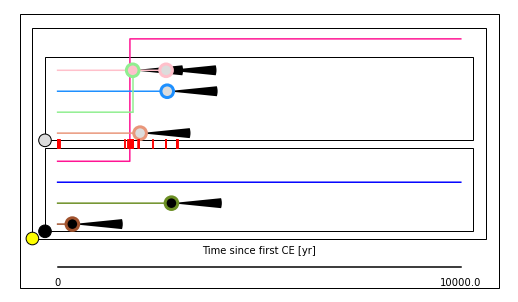

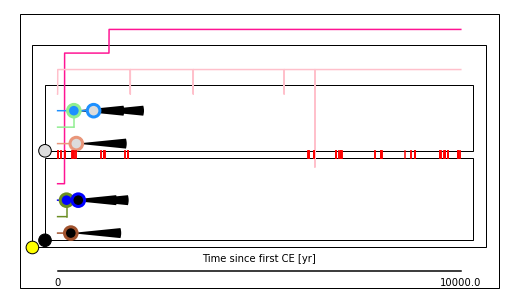

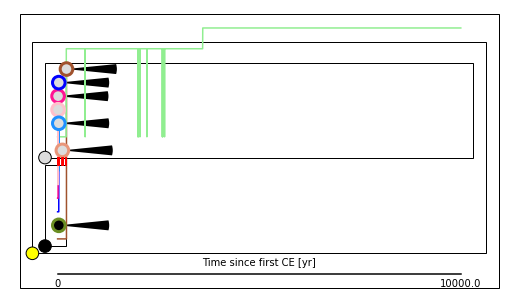

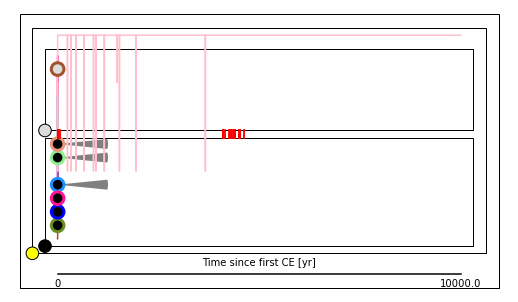

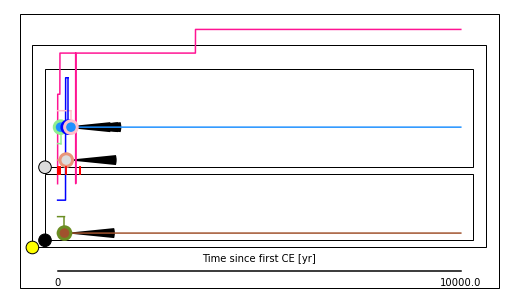

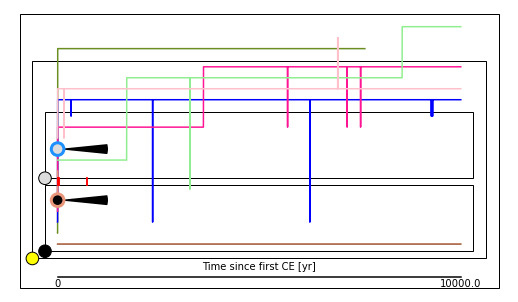

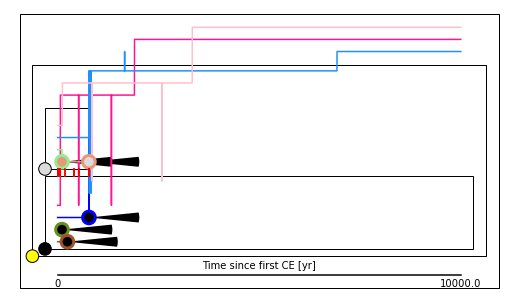

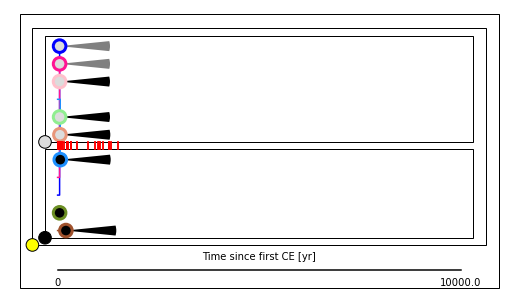

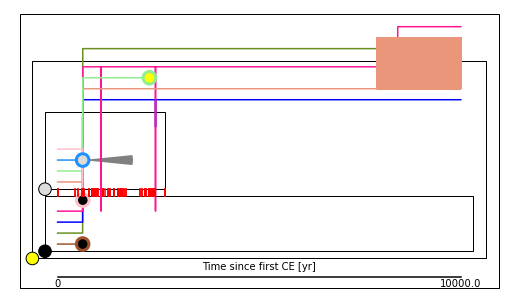

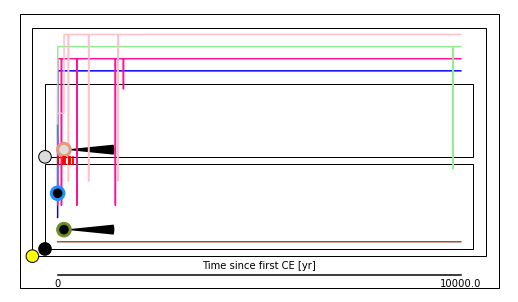

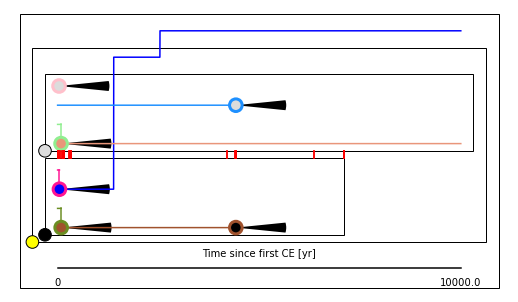

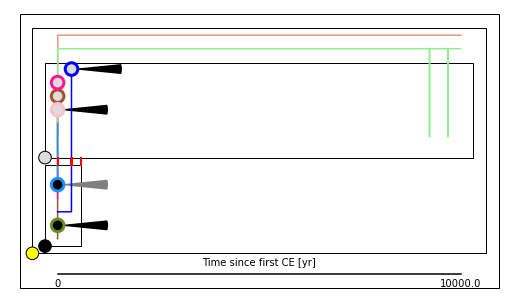

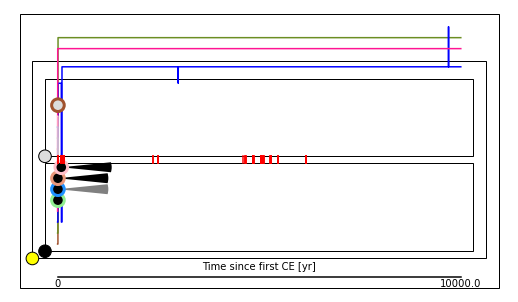

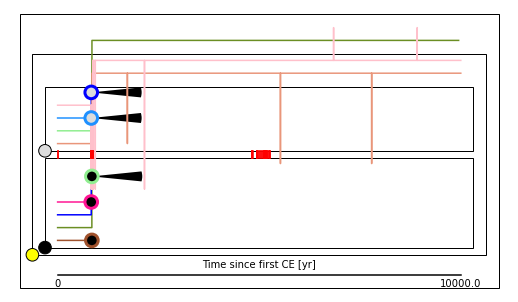

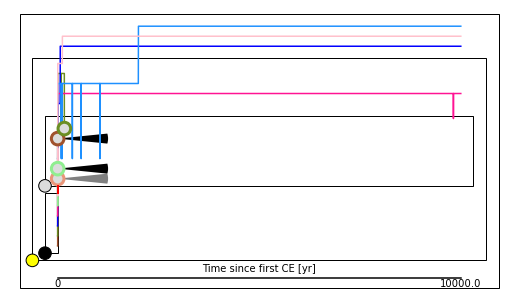

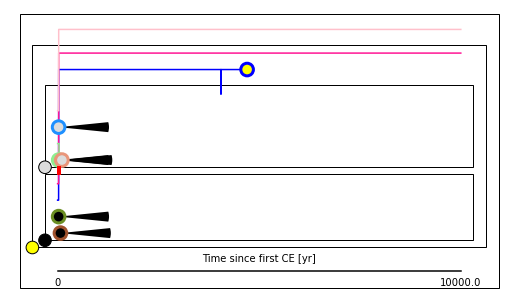

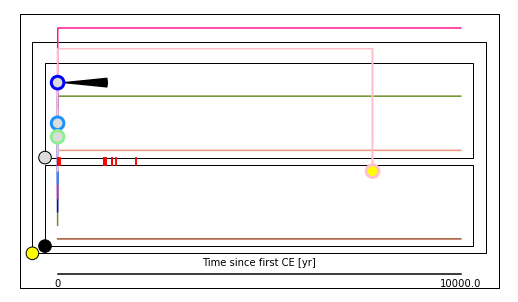

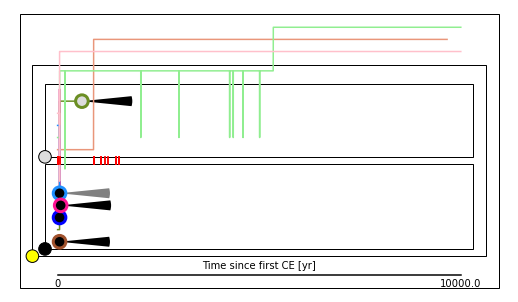

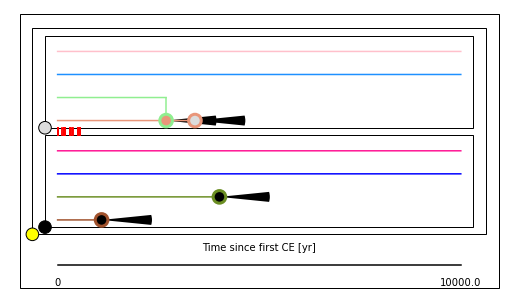

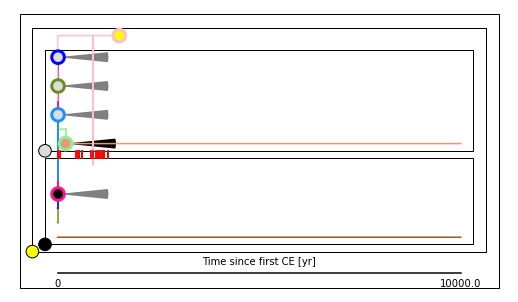

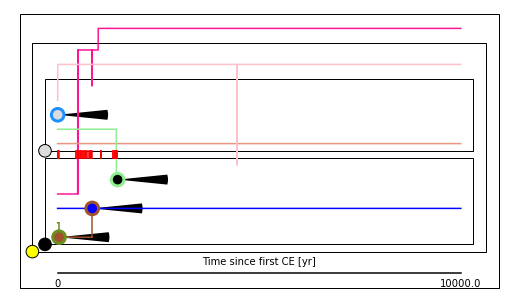

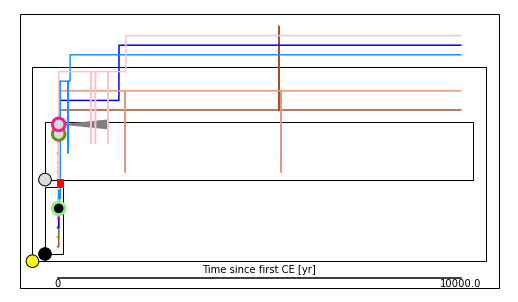

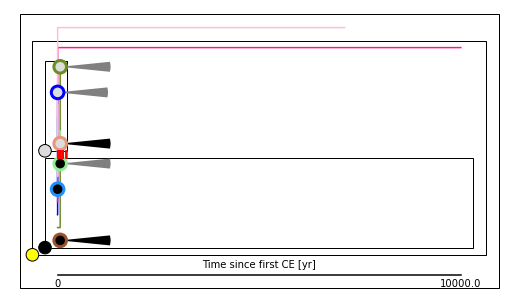

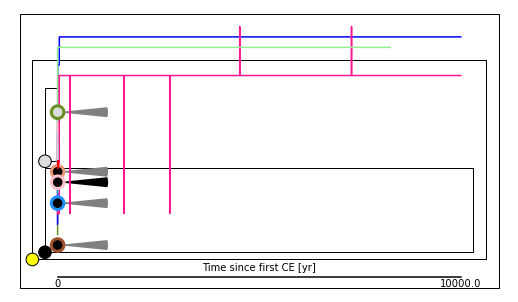

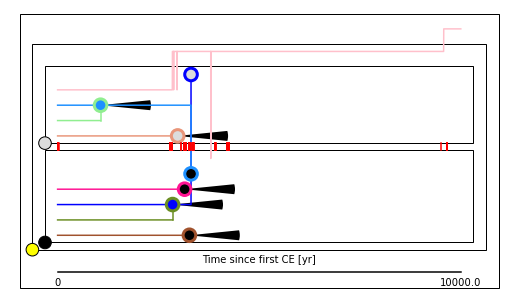

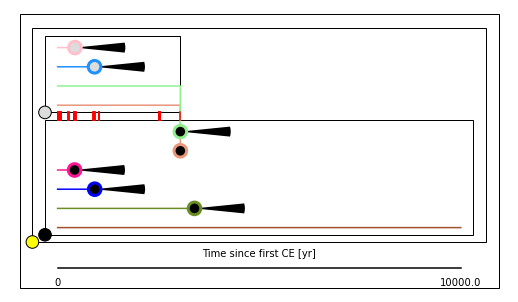

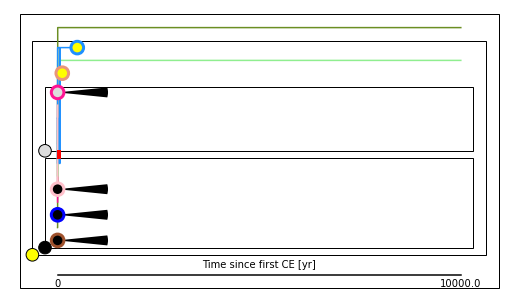

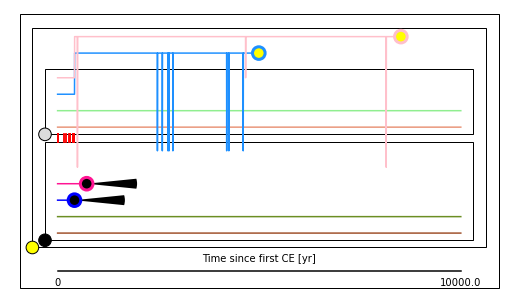

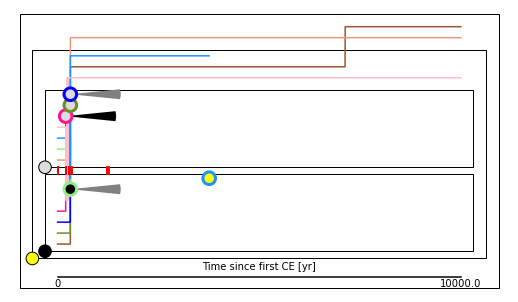

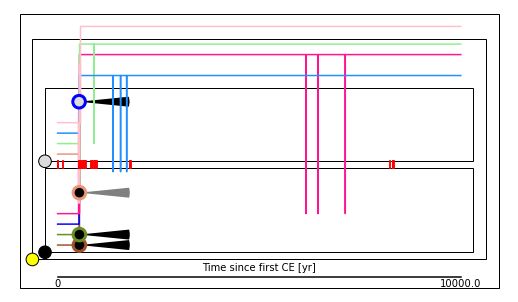

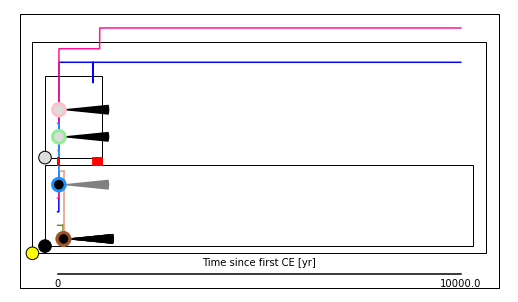

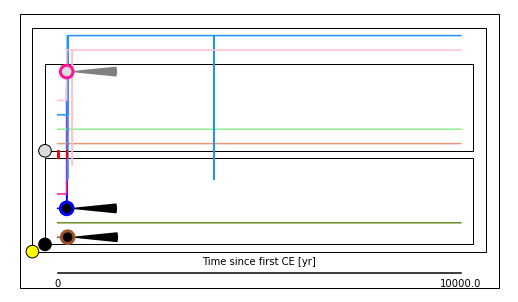

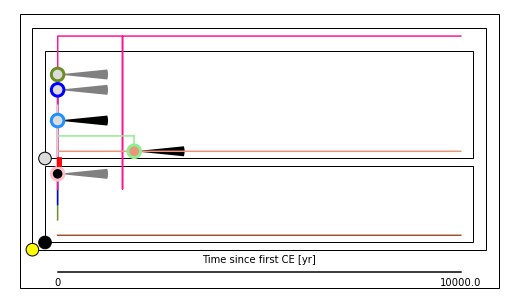

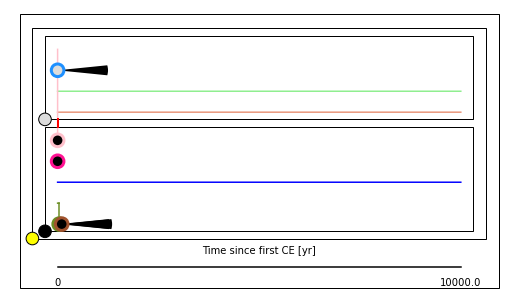

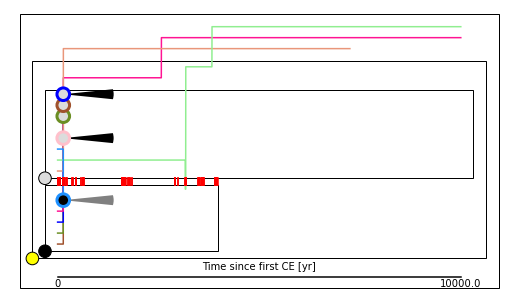

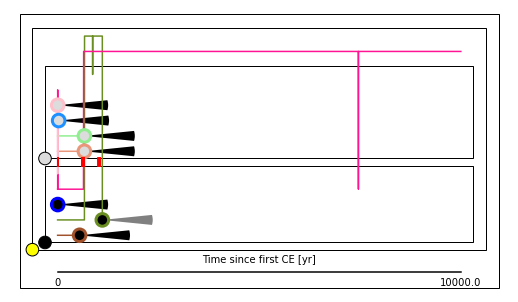

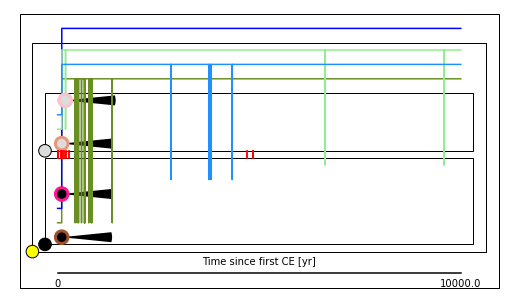

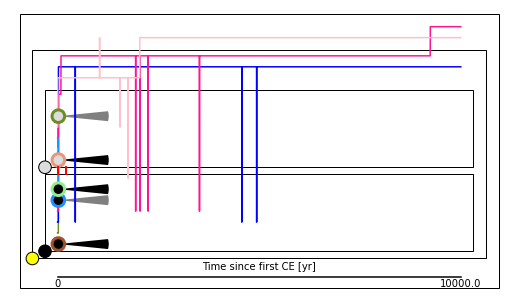

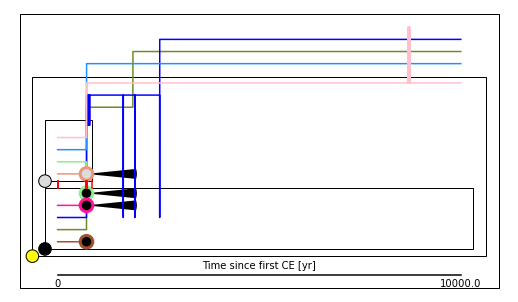

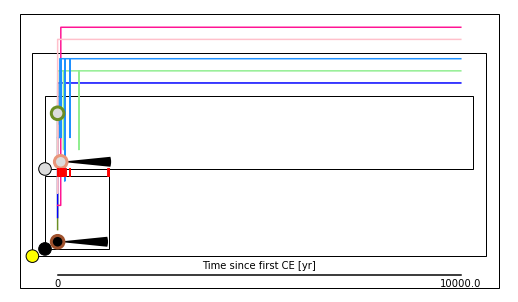

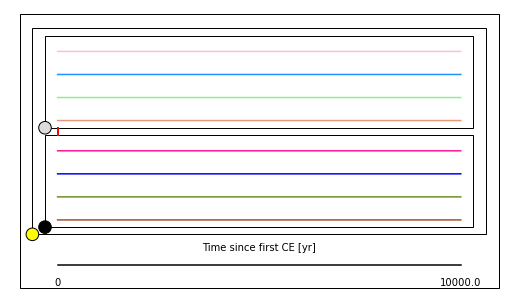

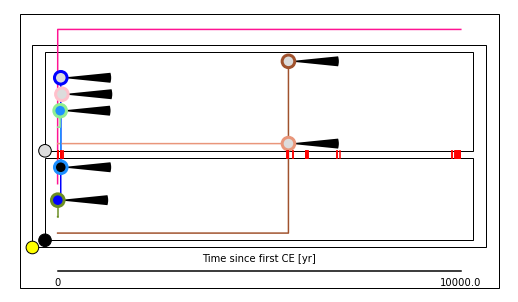

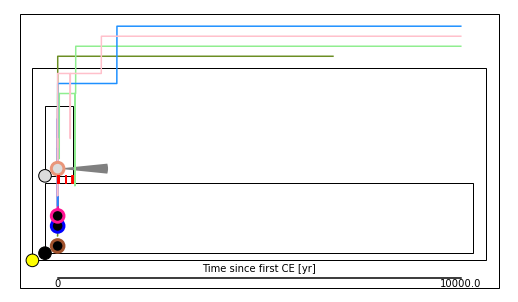

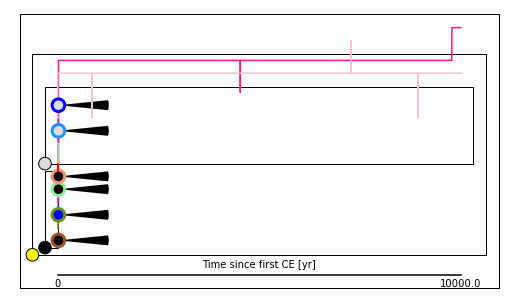

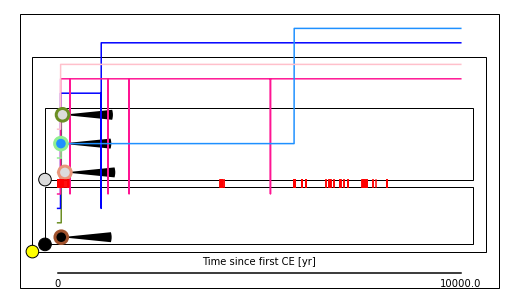

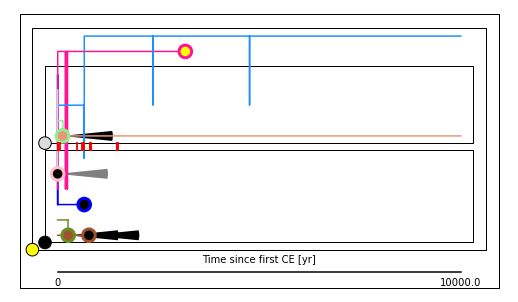

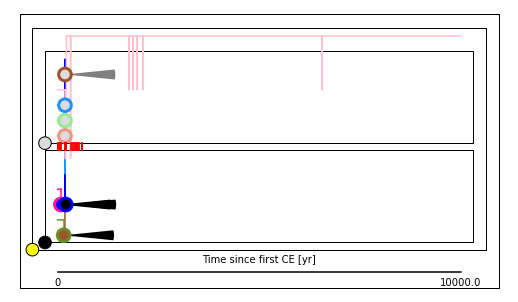

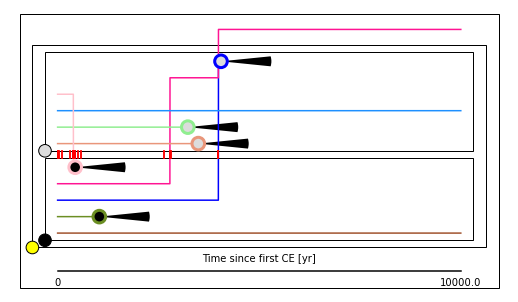

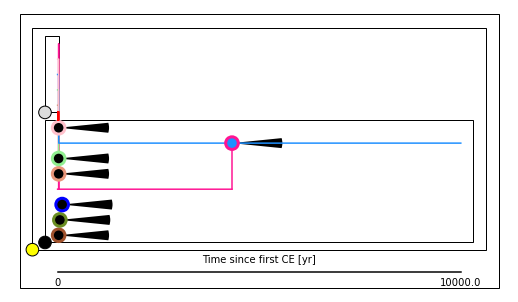

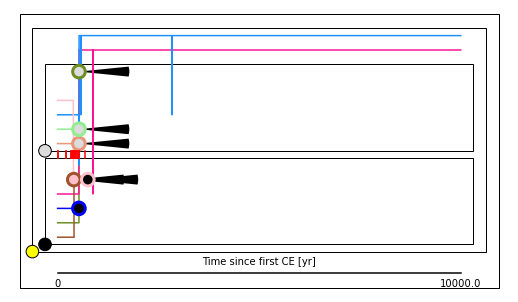

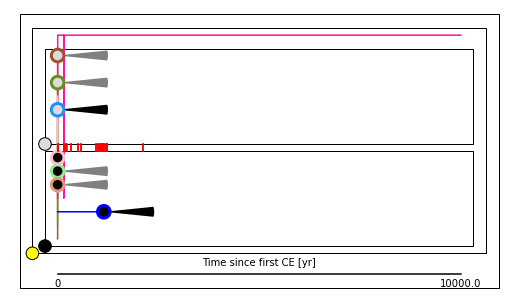

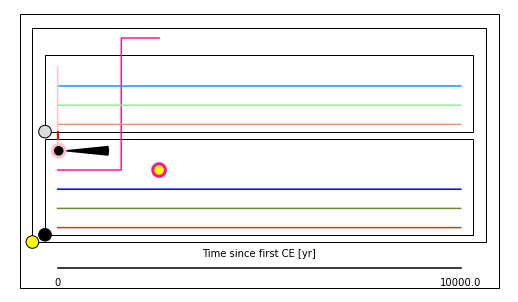

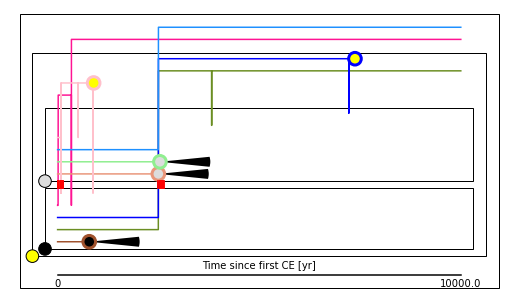

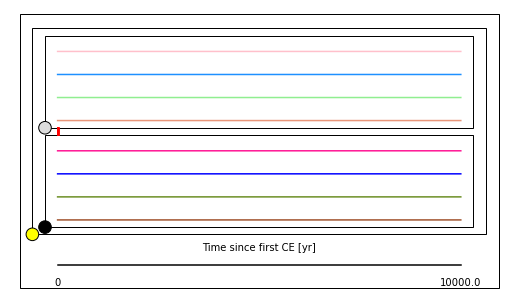

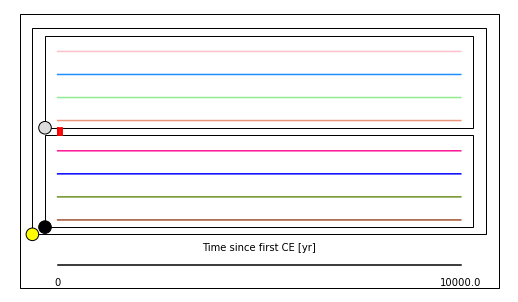

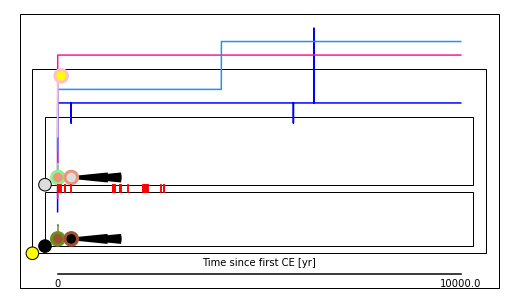

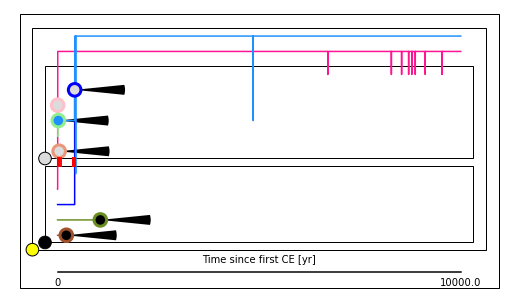

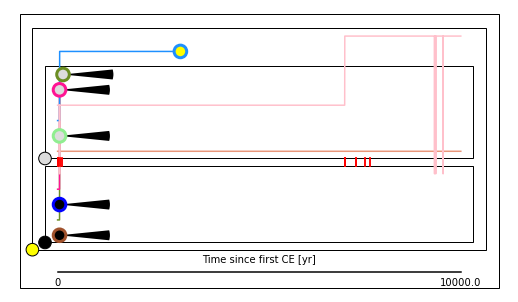

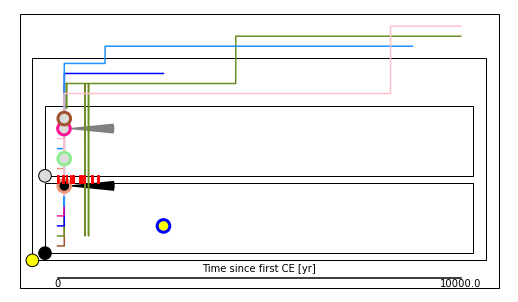

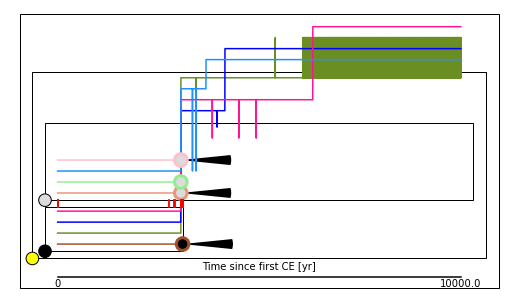

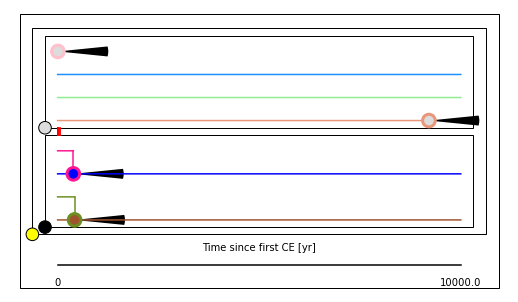

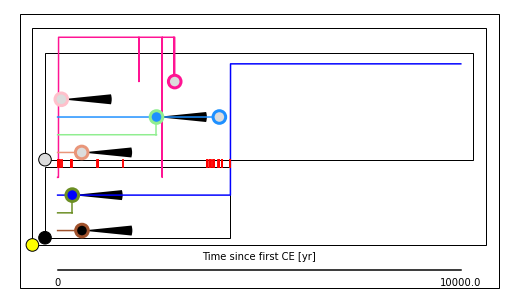

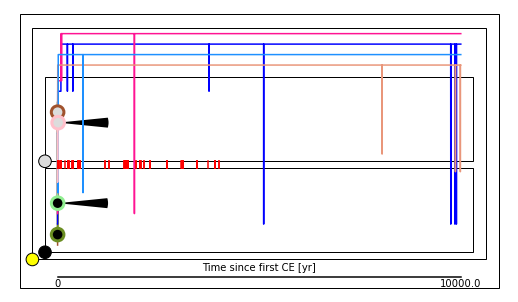

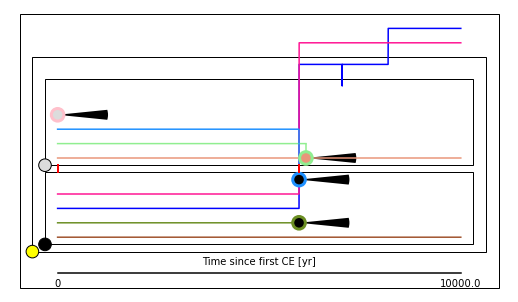

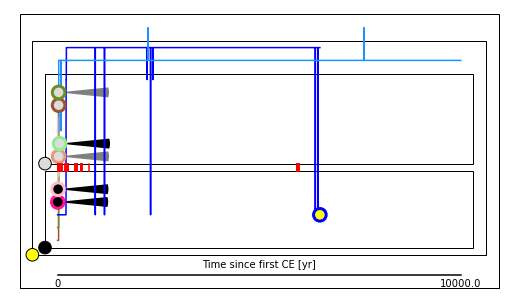

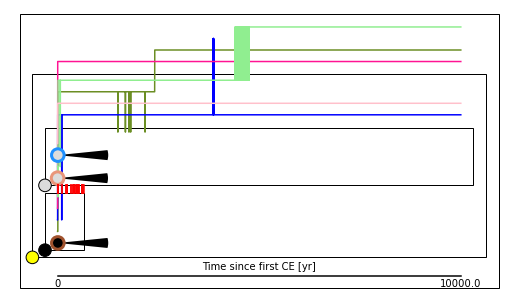

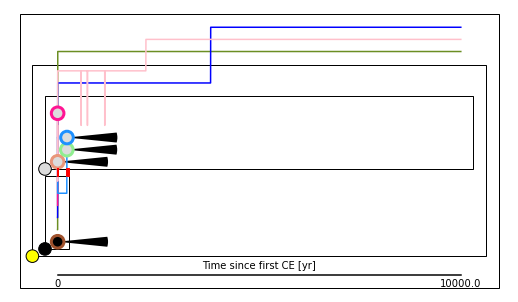

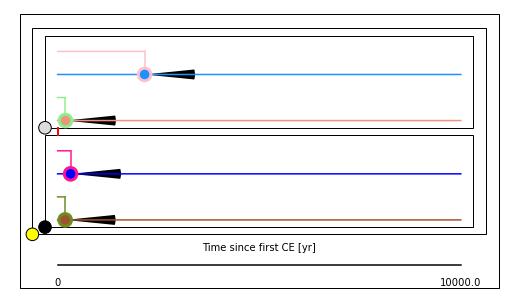

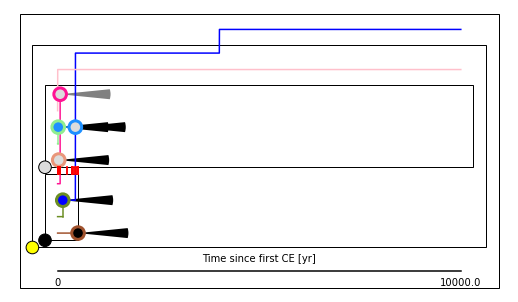

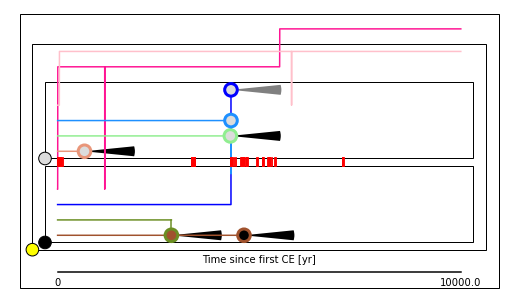

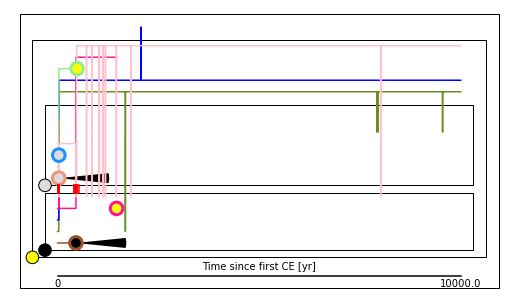

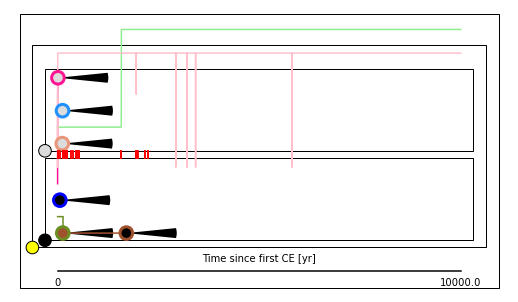

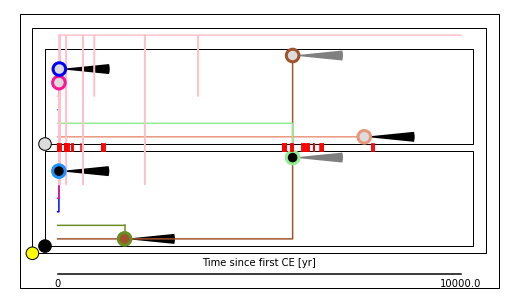

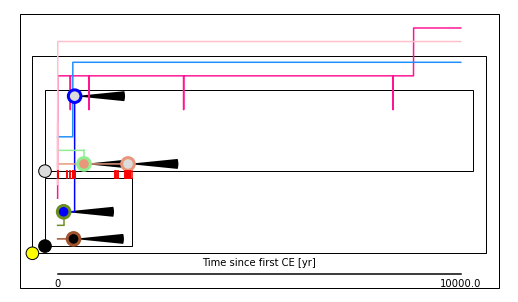

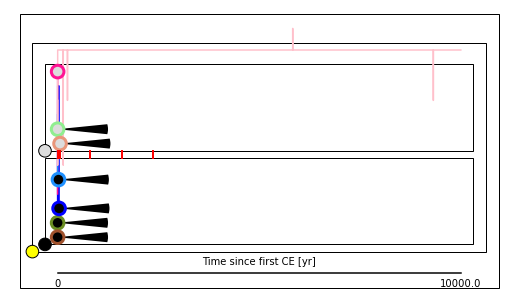

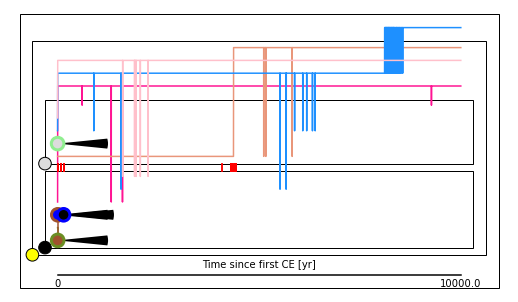

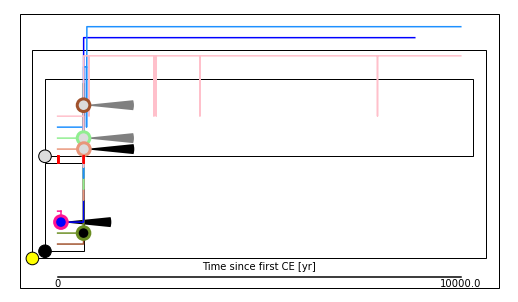

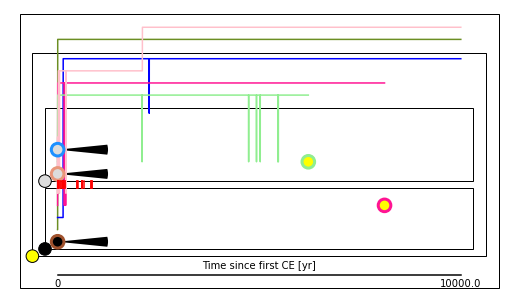

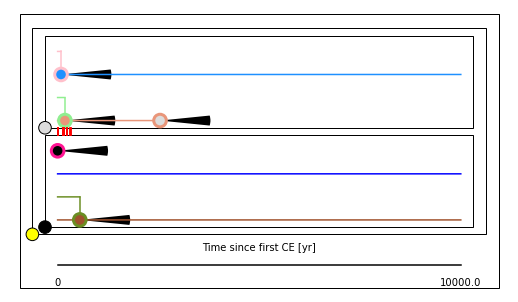

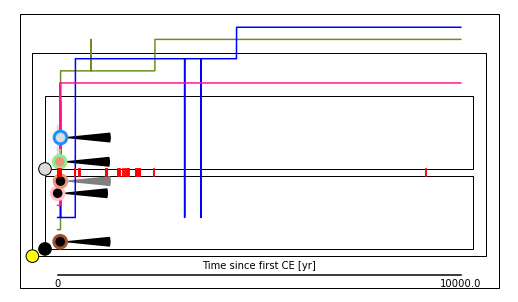

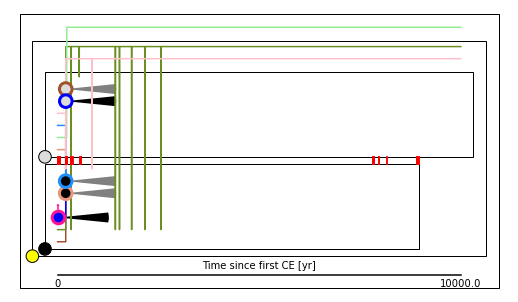

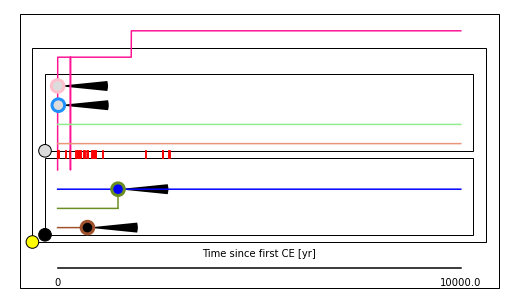

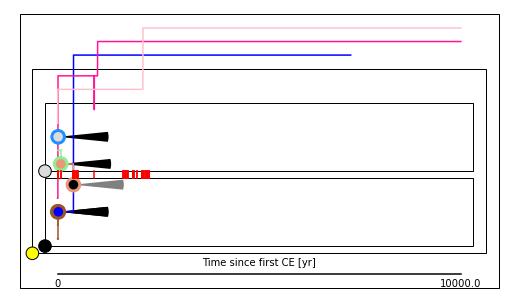

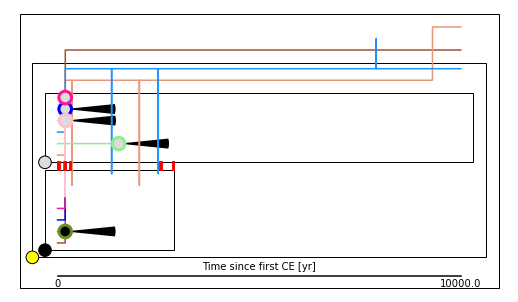

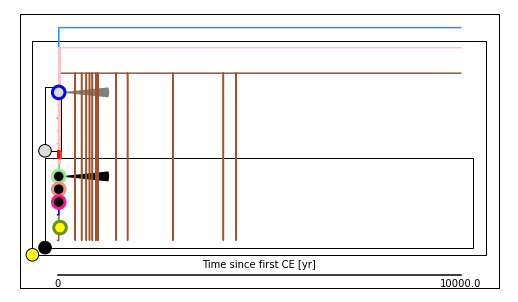

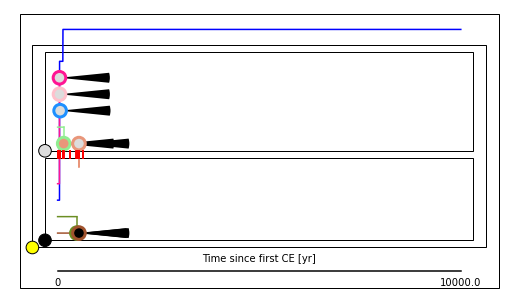

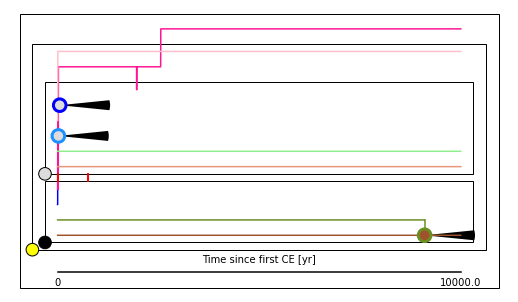

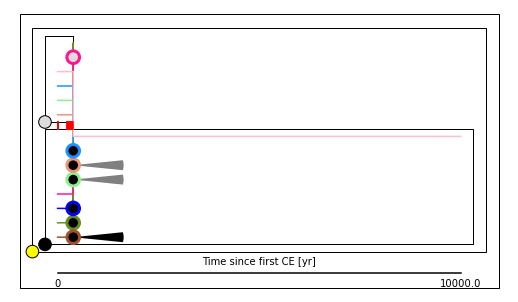

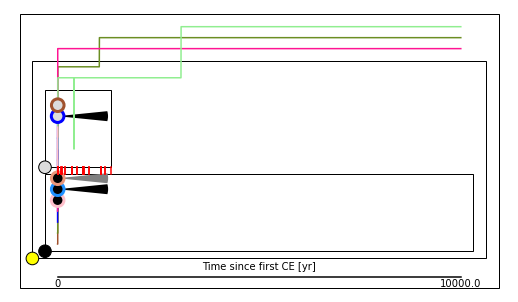

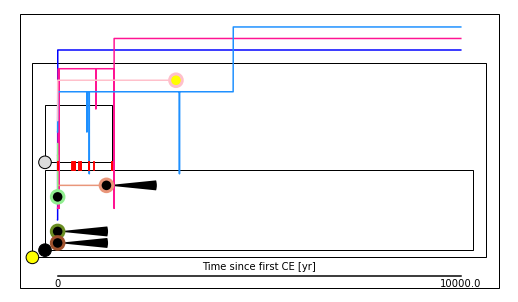

In [3]:
Nsys = 100

for i in range(Nsys):
    run_sim(filestem=f'test/test{i:04d}')
